<a href="https://colab.research.google.com/github/awaisrauf/explorations/blob/main/MMDet_Work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluating Robustness of Transformer Based Detectors


**Objective**: To understand robustness to 

Three models
1. DETR
2. Deformable DETR
3. RetinaNet

# Install Libraries

In [ ]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# install dependencies: (use cu111 because colab has CUDA 11.1)
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

# install mmcv-full thus we could use CUDA operators
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html

# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!pip install -e .

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████                   | 834.1 MB 1.4 MB/s eta 0:14:25tcmalloc: large alloc 1147494400 bytes == 0x56024e124000 @  0x7f0f52a57615 0x560213a613bc 0x560213b4218a 0x560213a641cd 0x560213b56b3d 0x560213ad8458 0x560213ad302f 0x560213a65aba 0x560213ad82c0 0x560213ad302f 0x560213a65aba 0x560213ad4cd4 0x560213b57986 0x560213ad4350 0x560213b57986 0x560213ad4350 0x560213b57986 0x560213ad4350 0x560213a65f19 0x560213aa9a79 0x560213a64b32 0x560213ad81dd 0x560213ad302f 0x560213a65aba 0x560213ad4cd4 0x560213ad302f 0x560213a65aba 0x560213ad3eae 0x560213a659da 0x560213ad4108 0x560213ad302f
     |████████████████▌               | 1055.7 MB 1.4 MB/s eta 0:11:24tcmalloc: large alloc 1434370048 bytes == 0x56029277a000 @  0x7f0f52a57615 0x560213a613bc 0x560213b4218a 0x560213a641cd 0x560213b56b3d 0x560213ad8458 0x560213ad302f 0x560213a65aba 0x560213ad82c0 0x560213ad302f 0x560213a65aba 0x560213ad4cd4 0x560213b57986 0x560213ad43

In [ ]:
!pip install imagecorruptions

In [ ]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import mmcv

# Data

In [ ]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

--2022-03-23 10:01:37--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.200.193
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.200.193|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip.1’

annotations_trainva 100%[===================>] 241.19M  36.7MB/s    in 7.3s    

2022-03-23 10:01:45 (33.2 MB/s) - ‘annotations_trainval2017.zip.1’ saved [252907541/252907541]



In [ ]:
!wget http://images.cocodataset.org/zips/val2017.zip

--2022-03-23 09:53:08--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.205.163
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.205.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip.1’

val2017.zip.1       100%[===================>] 777.80M  35.9MB/s    in 23s     

2022-03-23 09:53:31 (34.3 MB/s) - ‘val2017.zip.1’ saved [815585330/815585330]



In [ ]:
!unzip val2017.zip
!unzip annotations_trainval2017.zip

In [ ]:
# !mkdir data
# !mkdir data/coco
!mv val2017 data/coco/val2017
!mv annotations data/coco/annotations

mv: cannot move 'val2017' to 'data/coco/val2017/val2017': Directory not empty


# Robusntess of DETR


## Load DETR

In [ ]:
!wget https://download.openmmlab.com/mmdetection/v2.0/detr/detr_r50_8x2_150e_coco/detr_r50_8x2_150e_coco_20201130_194835-2c4b8974.pth
config_file = "/content/mmdetection/configs/detr/detr_r50_8x2_150e_coco.py"
checkpoint_file =  "/content/mmdetection/detr_r50_8x2_150e_coco_20201130_194835-2c4b8974.pth"

--2022-03-23 10:05:55--  https://download.openmmlab.com/mmdetection/v2.0/detr/detr_r50_8x2_150e_coco/detr_r50_8x2_150e_coco_20201130_194835-2c4b8974.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.254.186.233
Connecting to download.openmmlab.com (download.openmmlab.com)|47.254.186.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 166698982 (159M) [application/octet-stream]
Saving to: ‘detr_r50_8x2_150e_coco_20201130_194835-2c4b8974.pth.2’

detr_r50_8x2_150e_c 100%[===================>] 158.98M  8.55MB/s    in 19s     

2022-03-23 10:06:15 (8.27 MB/s) - ‘detr_r50_8x2_150e_coco_20201130_194835-2c4b8974.pth.2’ saved [166698982/166698982]



In [ ]:
# build the model from a config file and a checkpoint file
model = init_detector(config_file, checkpoint_file, device='cuda:0')

load checkpoint from local path: /content/mmdetection/detr_r50_8x2_150e_coco_20201130_194835-2c4b8974.pth


In [ ]:
# test a single image
img = '/content/mmdetection/resources/coco_test_12510.jpg'
result = inference_detector(model, img)

/content/mmdetection/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


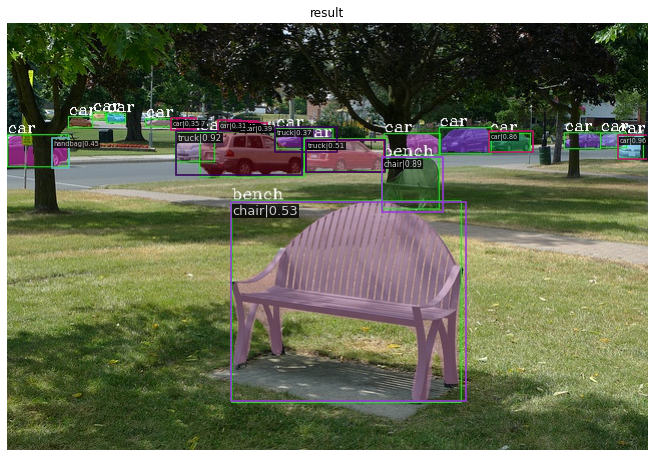

In [ ]:
# show the results
show_result_pyplot(model, img, result)

## Robustness

In [ ]:
!python tools/analysis_tools/test_robustness.py $config_file $checkpoint_file --out results/res.pkl --eval bbox --severities 4

severity = 2
```bash
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.264
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.421
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.271
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.095
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.283
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.403
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.239
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.384
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.422
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.164
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.456
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.624
 ```
 ___

 severity = 4
 ```bash
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.094
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.159
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.096
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.028
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.102
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.155
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.109
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.183
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.204
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.050
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.212
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.345
 ```

# Deformable DETR

In [ ]:
!wget https://download.openmmlab.com/mmdetection/v2.0/deformable_detr/deformable_detr_r50_16x2_50e_coco/deformable_detr_r50_16x2_50e_coco_20210419_220030-a12b9512.pth

--2022-03-23 09:50:31--  https://download.openmmlab.com/mmdetection/v2.0/deformable_detr/deformable_detr_r50_16x2_50e_coco/deformable_detr_r50_16x2_50e_coco_20210419_220030-a12b9512.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.254.186.233
Connecting to download.openmmlab.com (download.openmmlab.com)|47.254.186.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 163872102 (156M) [application/octet-stream]
Saving to: ‘deformable_detr_r50_16x2_50e_coco_20210419_220030-a12b9512.pth’

deformable_detr_r50 100%[===================>] 156.28M  7.19MB/s    in 22s     

2022-03-23 09:50:54 (7.03 MB/s) - ‘deformable_detr_r50_16x2_50e_coco_20210419_220030-a12b9512.pth’ saved [163872102/163872102]



In [ ]:
config_file = "/content/mmdetection/configs/deformable_detr/deformable_detr_r50_16x2_50e_coco.py"
# download the checkpoint from model zoo and put it in `checkpoints/`
# https://download.openmmlab.com/mmdetection/v2.0/detr/detr_r50_8x2_150e_coco/detr_r50_8x2_150e_coco_20201130_194835-2c4b8974.pth
checkpoint_file =  "/content/mmdetection/deformable_detr_r50_16x2_50e_coco_20210419_220030-a12b9512.pth"

In [ ]:
# build the model from a config file and a checkpoint file
model = init_detector(config_file, checkpoint_file, device='cuda:0')

load checkpoint from local path: /content/mmdetection/deformable_detr_r50_16x2_50e_coco_20210419_220030-a12b9512.pth


In [ ]:
# test a single image
img = '/content/mmdetection/resources/coco_test_12510.jpg'
result = inference_detector(model, img)

/content/mmdetection/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


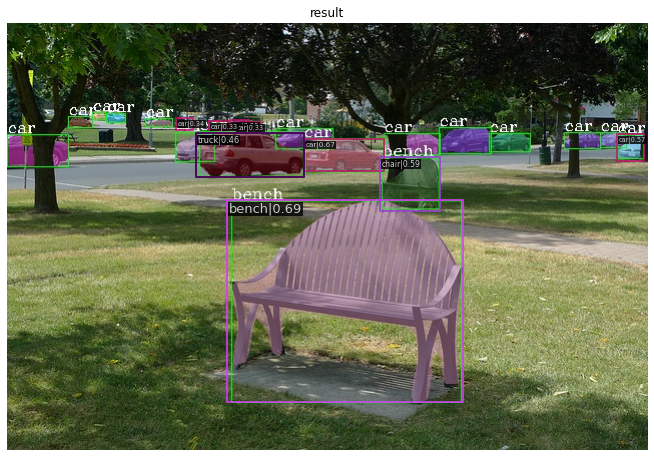

In [ ]:
# show the results
show_result_pyplot(model, img, result)

### Robustness

In [ ]:
!python tools/analysis_tools/test_robustness.py $config_file $checkpoint_file --out results/res_dform.pkl --eval bbox --severities 4


Testing gaussian_noise at severity 4
loading annotations into memory...
Done (t=0.66s)
creating index...
index created!
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
load checkpoint from local path: /content/mmdetection/deformable_detr_r50_16x2_50e_coco_20210419_220030-a12b9512.pth
[                                                  ] 0/5000, elapsed: 0s, ETA:/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until 

```bash
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.119
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.188
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.125
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.049
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.131
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.183
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.155
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.261
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.282
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.094
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.296
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.440

 ```

#**bold text** Retina Net

In [ ]:
!wget https://download.openmmlab.com/mmdetection/v2.0/fp16/retinanet_r50_fpn_fp16_1x_coco/retinanet_r50_fpn_fp16_1x_coco_20200702-0dbfb212.pth

--2022-03-23 09:56:53--  https://download.openmmlab.com/mmdetection/v2.0/fp16/retinanet_r50_fpn_fp16_1x_coco/retinanet_r50_fpn_fp16_1x_coco_20200702-0dbfb212.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.254.186.233
Connecting to download.openmmlab.com (download.openmmlab.com)|47.254.186.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76320440 (73M) [application/octet-stream]
Saving to: ‘retinanet_r50_fpn_fp16_1x_coco_20200702-0dbfb212.pth’

retinanet_r50_fpn_f 100%[===================>]  72.78M  11.4MB/s    in 7.4s    

2022-03-23 09:57:02 (9.88 MB/s) - ‘retinanet_r50_fpn_fp16_1x_coco_20200702-0dbfb212.pth’ saved [76320440/76320440]



In [ ]:
config_file = "configs/retinanet/retinanet_r50_fpn_1x_coco.py"
checkpoint_file =  "retinanet_r50_fpn_fp16_1x_coco_20200702-0dbfb212.pth"

In [ ]:
# build the model from a config file and a checkpoint file
model = init_detector(config_file, checkpoint_file, device='cuda:0')

load checkpoint from local path: retinanet_r50_fpn_fp16_1x_coco_20200702-0dbfb212.pth


In [ ]:
img = '/content/mmdetection/resources/coco_test_12510.jpg'
result = inference_detector(model, img)

/content/mmdetection/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


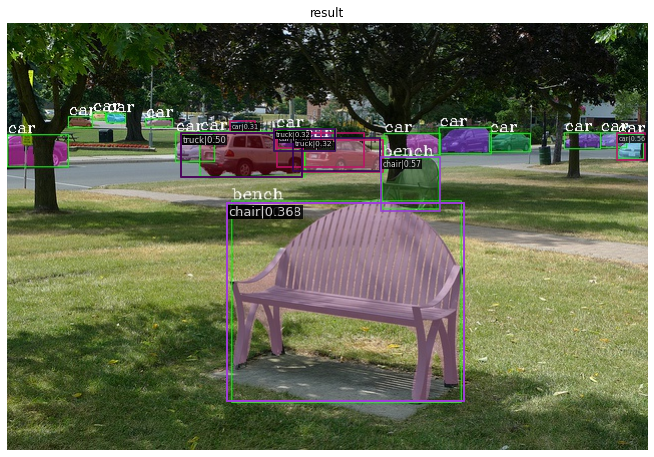

In [ ]:
# show the results
show_result_pyplot(model, img, result)

## Robustness

In [ ]:
!python tools/analysis_tools/test_robustness.py $config_file $checkpoint_file --out results/res.pkl --eval bbox --severities 4


Testing gaussian_noise at severity 4
loading annotations into memory...
Done (t=0.68s)
creating index...
index created!
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
load checkpoint from local path: retinanet_r50_fpn_fp16_1x_coco_20200702-0dbfb212.pth
[                                                  ] 0/5000, elapsed: 0s, ETA:/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (T

# Overall Results

([<matplotlib.axis.XTick at 0x7f76187d4cd0>,
 [Text(0, 0, 'RetinaNet'), Text(0, 0, 'DETR'), Text(0, 0, 'Deformable DETR')])

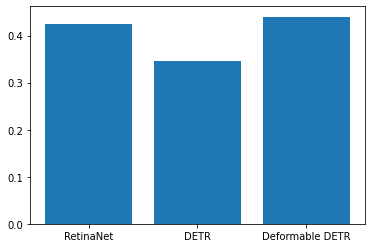

In [ ]:
models = ['RetinaNet', 'DETR', 'Deformable DETR']
results  = [0.424, 0.345, 0.440]

import matplotlib.pyplot as plt

x = list(range(3))
plt.bar(x, results)
plt.xticks(x, models)

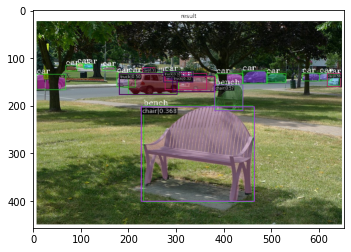

In [ ]:
im_paths =["retina_img.png", "detr_img.png", "defr_detr.png"]
fig = plt.subplot()
img = plt.imread('/content/mmdetection/results/'+im_paths[0])
plt.imshow(img)


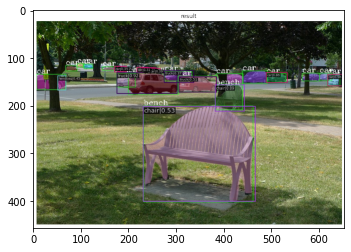

In [ ]:
fig = plt.subplot()
img = plt.imread('/content/mmdetection/results/'+im_paths[1])
plt.imshow(img)

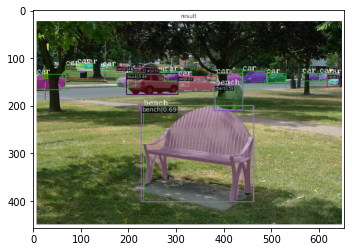

In [ ]:
fig = plt.subplot()
img = plt.imread('/content/mmdetection/results/'+im_paths[2])
plt.imshow(img)

In [ ]:
from PIL import Image

image = Image.open('/content/mmdetection/results/defr_detr.png')
image.show()